#    Filtering and smoothing - SEIR model 

Filtering and smoothing (belief propagation on an HMM) in the TT format for the SEIR model.

In [26]:
import torch as tn
import torchtt as tntt
import TTCME
import matplotlib.pyplot as plt 
import datetime
import numpy as np

tn.set_default_tensor_type(tn.DoubleTensor)
qtt = True

tme_total = datetime.datetime.now()


### Setup 

The model is created. It contains 4 species: Susceptible, Exposed, Infected, Recovered.

In [27]:
r1 = TTCME.ChemicalReaction(['S','E','I','R'],'S+I->E+I', 0.1)
r2 = TTCME.ChemicalReaction(['S','E','I','R'],'E->I',     0.5)
r3 = TTCME.ChemicalReaction(['S','E','I','R'],'I->S',     1.0)
r4 = TTCME.ChemicalReaction(['S','E','I','R'],'S->',      0.01)
r5 = TTCME.ChemicalReaction(['S','E','I','R'],'E->',      0.01)
r6 = TTCME.ChemicalReaction(['S','E','I','R'],'I->R',     0.01)
r7 = TTCME.ChemicalReaction(['S','E','I','R'],'->S',      0.4)

mdl = TTCME.ReactionSystem(['S','E','I','R'],[r1, r2 ,r3, r4, r5 ,r6, r7])

print(mdl)

N = [128,128,64,32]
x0 = [50,4,0,0]

Att = mdl.generatorTT(N)

Chemical reaction system
Species involved: S,E,I,R
Reactions:
Chemical reaction: S+I->E+I with parameters: []
Chemical reaction: E->I with parameters: []
Chemical reaction: I->S with parameters: []
Chemical reaction: S-> with parameters: []
Chemical reaction: E-> with parameters: []
Chemical reaction: I->R with parameters: []
Chemical reaction: ->S with parameters: []


Sample a trajectory and add noise (see figure).
The noise model for the generation as well as the noise model for the reconstruction is lognormal. 

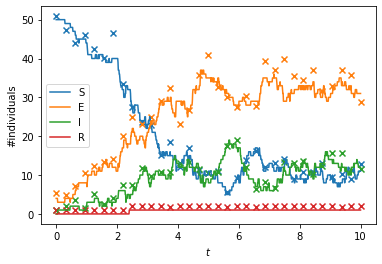

In [28]:
No = 33
dT = 0.3125

np.random.seed(128)

time_observation = np.arange(No)*dT
time_grid = np.linspace(0,time_observation[-1],1000)

reaction_time,reaction_jumps,reaction_indices = mdl.ssa_single(x0,time_grid[-1])
states = mdl.jump_process_to_states(time_observation, reaction_time, reaction_jumps)
states_all = mdl.jump_process_to_states(time_grid, reaction_time, reaction_jumps)

s1 = 0.1
s2 = 0.1
s3 = 0.1
s4 = 0.05
observations = states + np.hstack((np.random.normal(0,1,(states.shape[0],3)),np.random.normal(0,0.000001,[states.shape[0],1])))
observations = np.hstack((np.random.lognormal(np.log(states[:,0]+1),s1).reshape([-1,1]) , np.random.lognormal(np.log(states[:,1]+1),s2).reshape([-1,1]) , np.random.lognormal(np.log(states[:,2]+1),s3).reshape([-1,1]) , np.random.lognormal(np.log(states[:,3]+1),s4).reshape([-1,1])))

plt.figure()
plt.plot(time_grid, states_all)
plt.scatter(time_observation, observations[:,0],marker='x')
plt.scatter(time_observation, observations[:,1],marker='x')
plt.scatter(time_observation, observations[:,2],marker='x')
plt.scatter(time_observation, observations[:,3],marker='x')
plt.xlabel(r'$t$')
plt.ylabel(r'#individuals')
plt.legend(['S','E','I','R'])

Construct the CME generator in the TT format and instantiate the observation operator.

In [29]:
Att = mdl.generatorTT(N)
if qtt: Aqtt = Att.to_qtt()

p0 = TTCME.pdf.SingularPMF(N, x0)

observation_operator = TTCME.pdf.LogNormalObservation(N, [s1,s2,s3,s4])

### Forward pass

Perform the forward pass (the filtering).

In [30]:

if qtt:
    fwd_int = TTCME.TimeIntegrator.TTInt(Aqtt, epsilon = 1e-6, N_max = 8, dt_max = 1.0,method='cheby')
    pk = p0.dofs.to_qtt()
else:
    fwd_int = TTCME.TimeIntegrator.TTInt(Att, epsilon = 1e-6, N_max = 8, dt_max = 1.0,method='cheby')
    pk = p0.dofs.clone()



Forward pass.

In [31]:
P_fwd = [pk.clone()]
ranks_fwd = [[0,max(p0.dofs.R)]]
time = 0
for i in range(1,No):
    
    # likelihood for the current observation    
    po = observation_operator.likelihood(observations[i,:])
        
    if qtt: po = po.to_qtt()
    
    tme = datetime.datetime.now()

    # prediction
    pks = fwd_int.solve(pk, dT, intervals = 6,return_all=True,qtt=qtt) 

    # correction step
    if qtt :
        P_fwd += [p[...,-1].round(1e-8) for p in pks] 
        for k in range(len(pks)):
            time+=dT/len(pks)
            ranks_fwd += [[time,max(pks[k][...,-1].round(1e-10).R)]]
        pk = pks[-1][...,-1]
    else:
        P_fwd += [p[:,:,:,:,-1] for p in pks] 
        pk = pks[-1][:,:,:,:,-1]
        
    tme = datetime.datetime.now() - tme

    print('\tmax rank before observation ',max(pk.round(1e-10).R),' not rounded ',max(pk.R))
    p_next = pk * po
    p_next = p_next.round(1e-10)
    p_next = p_next / p_next.sum()
    print('\tMax rank after observation ',max(p_next.R))
    ranks_fwd += [[time,max(p_next.R)]]
    pk = p_next 
    
    # P_fwd.append(P)
    
    print('observation ',i+1,' at time ',time_observation[i],' is ' ,observations[i,:],' time elapsed',tme)

ranks_fwd = np.array(ranks_fwd)

	max rank before observation  35  not rounded  70
	Max rank after observation  9
observation  2  at time  0.3125  is  [47.35237624  4.80282159  2.07888713  1.01152643]  time elapsed 0:00:08.182249
	max rank before observation  49  not rounded  98
	Max rank after observation  21
observation  3  at time  0.625  is  [44.02909448  7.15764085  3.62513916  1.03067759]  time elapsed 0:00:10.838246
	max rank before observation  74  not rounded  150
	Max rank after observation  13
observation  4  at time  0.9375  is  [46.06380254 10.44578699  1.57524404  1.05179574]  time elapsed 0:00:15.544366
	max rank before observation  62  not rounded  124
	Max rank after observation  30
observation  5  at time  1.25  is  [42.40686791 12.23250286  5.14101293  0.94991066]  time elapsed 0:00:13.691316
	max rank before observation  91  not rounded  182
	Max rank after observation  25
observation  6  at time  1.5625  is  [40.05894149 13.26074627  2.50719761  0.89903638]  time elapsed 0:00:19.122257
	max rank b

### Backward pass

The smoothing.

In [32]:
pk = tntt.ones(N)
if qtt:
    A_qtt = Att.t().to_qtt()
    bck_int = TTCME.TimeIntegrator.TTInt(A_qtt, epsilon = 1e-6, N_max = 8, dt_max = 1.0,method='cheby')
    pk = pk.to_qtt()
else:
    bck_int = TTCME.TimeIntegrator.TTInt(Att.t(), epsilon = 1e-6, N_max = 8, dt_max = 1.0,method='cheby')

In [33]:
P_bck = []
ranks_bck = []
for i in range(No-1,0,-1):
    
    po = observation_operator.likelihood(observations[i,:])
        
    po = po / po.sum()

    if qtt: po = po.to_qtt()

    tme = datetime.datetime.now()

    print('\tmax rank before observation ',max(pk.R),' rank of observation ',max(po.R))
    pk = (pk * po).round(1e-10)
    print('\tmax rank after observation ',max(pk.R))

    pks = bck_int.solve(pk, dT, intervals = 6,return_all=True,qtt = qtt)
    
    if qtt :
        P_bck += [p[...,0].round(1e-8) for p in pks] 
        pk = pks[-1][...,-1]
    else:
        P_bck += [p[:,:,:,:,0] for p in pks]
        pk = pks[-1][:,:,:,:,-1]
        
    tme = datetime.datetime.now() - tme
    
    p_next = pk.round(1e-10)
    p_next = p_next / p_next.sum()
    
    pk = p_next 
    
    
    print('observation ',i+1,' at time ',time_observation[i],' is ' ,observations[i,:] ,' time elapsed',tme,' s')

P_bck.append(pk)
P_bck = P_bck[::-1]

	max rank before observation  1  rank of observation  6
	max rank after observation  6
observation  33  at time  10.0  is  [12.76775399 28.8117667  11.68706094  1.98757745]  time elapsed 0:00:25.082707  s
	max rank before observation  112  rank of observation  7
	max rank after observation  34
observation  32  at time  9.6875  is  [ 8.92583504 35.86472216 11.35562847  2.11969338]  time elapsed 0:00:24.863327  s
	max rank before observation  115  rank of observation  7
	max rank after observation  45
observation  31  at time  9.375  is  [10.25207261 36.92185617 15.57557775  1.80476601]  time elapsed 0:00:27.534390  s
	max rank before observation  142  rank of observation  6
	max rank after observation  43
observation  30  at time  9.0625  is  [ 9.43347579 33.02416621 15.58045623  1.98497662]  time elapsed 0:00:29.061911  s
	max rank before observation  160  rank of observation  7
	max rank after observation  44
observation  29  at time  8.75  is  [13.08717853 31.66577245 12.41205267  1.

<h2> Combine messages </h2>

The messages from the forward and the backward pass are combined (by multiplication).
Moreover, the expected value and the variances are calculated.

In [36]:
P_hmm = []

x1, x2, x3, x4 = tntt.meshgrid([tn.arange(n, dtype = tn.float64) for n in N])

Es = []
Vs = []

if qtt:
    x1 = x1.to_qtt()
    x2 = x2.to_qtt()
    x3 = x3.to_qtt()
    x4 = x4.to_qtt()
    
for i in range(len(P_bck)):
    Pf = P_fwd[i]
    Pb = P_bck[i]

    Z = tntt.dot(Pf,Pb)
    
    mean = [tntt.dot(Pf,Pb*x1)/Z, tntt.dot(Pf,Pb*x2)/Z, tntt.dot(Pf,Pb*x3)/Z, tntt.dot(Pf,Pb*x4)/Z]
    var = [tntt.dot(Pf*x1,Pb*x1)/Z-mean[0]**2, tntt.dot(Pf*x2,Pb*x2)/Z-mean[1]**2, tntt.dot(Pf*x3,Pb*x3)/Z-mean[2]**2, tntt.dot(Pf*x4,Pb*x4)/Z-mean[3]**2]

    Es.append(mean)
    Vs.append(var)
    
    
Es = np.array(Es)
Vs = np.sqrt(np.array(Vs))
Vs = np.nan_to_num(Vs)
tme_total = datetime.datetime.now() - tme_total



print()
print('Elapsed time',tme_total)
print('Total size forward messages ',sum([tntt.numel(p) for p in P_fwd])*8/1e6,' MB')
print('Total size backward messagea ',sum([tntt.numel(p) for p in P_bck])*8/1e6,' MB')
print()


Elapsed time 2022-08-12 16:54:30.654660
Total size forward messages  105.262096  MB
Total size backward messagea  129.293312  MB



/tmp/ipykernel_3493608/866946032.py:28: RuntimeWarning: invalid value encountered in sqrt
  Vs = np.sqrt(np.array(Vs))


### Plots

The ranks during the loops are also ploted to show that incorporating the measurement acts reduces the rank.

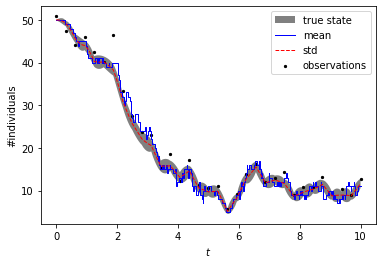

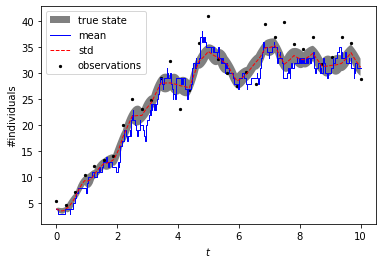

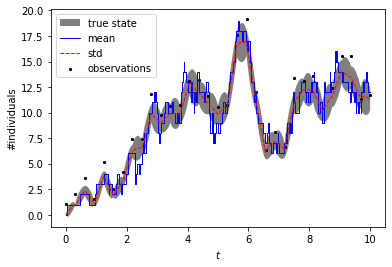

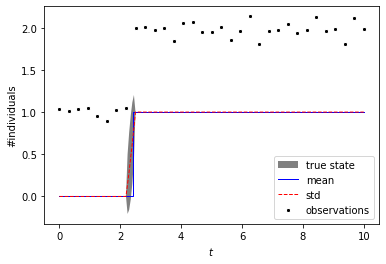

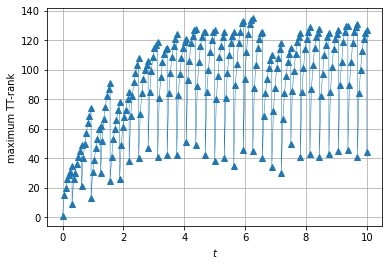

In [35]:
import tikzplotlib

n  = Es.shape[0]
time_plot = np.linspace(0,(No-1)*dT,n)
plt.figure()
plt.fill(np.concatenate((time_plot,time_plot[::-1])), np.concatenate((Es[:,0] - Vs[:,0],Es[::-1,0] + Vs[::-1,0])), 'grey') 
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,0],2)[:-1],'b',linewidth=1,label='true state')
plt.plot(time_plot,Es[:,0],'r--',linewidth=1,label='mean')
plt.scatter(time_observation,observations[:,0],s=5,c='k',label='observations')
plt.xlabel(r'$t$')
plt.ylabel(r'#individuals')
plt.legend(['true state','mean','std','observations'])
tikzplotlib.save('./seir_filter_S.tex',table_row_sep=r"\\")

plt.figure()
plt.fill(np.concatenate((time_plot,time_plot[::-1])), np.concatenate((Es[:,1] - Vs[:,1],Es[::-1,1] + Vs[::-1,1])), 'grey') 
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,1],2)[:-1],'b',linewidth=1)
plt.plot(time_plot,Es[:,1],'r--',linewidth=1)
plt.scatter(time_observation,observations[:,1],s=5,c='k')
plt.legend(['true state','mean','std','observations'])
plt.xlabel(r'$t$')
plt.ylabel(r'#individuals')
tikzplotlib.save('./seir_filter_E.tex',table_row_sep=r"\\")

plt.figure()
plt.fill(np.concatenate((time_plot,time_plot[::-1])), np.concatenate((Es[:,2] - Vs[:,2],Es[::-1,2] + Vs[::-1,2])), 'grey') 
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,2],2)[:-1],'b',linewidth=1)
plt.plot(time_plot,Es[:,2],'r--',linewidth=1)
plt.scatter(time_observation,observations[:,2],s=5,c='k',marker='x')
plt.legend(['true state','mean','std','observations'])
plt.xlabel(r'$t$')
plt.ylabel(r'#individuals')
tikzplotlib.save('./seir_filter_I.tex',table_row_sep=r"\\")

plt.figure()
plt.fill(np.concatenate((time_plot,time_plot[::-1])), np.concatenate((Es[:,3] - Vs[:,3],Es[::-1,3] + Vs[::-1,3])), 'grey') 
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,3],2)[:-1],'b',linewidth=1)
plt.plot(time_plot,Es[:,3],'r--',linewidth=1)
plt.scatter(time_observation,observations[:,3],marker="x", c="k",  s=5)
plt.legend(['true state','mean','std','observations'])
plt.xlabel(r'$t$')
plt.ylabel(r'#individuals')
tikzplotlib.save('./seir_filter_R.tex',table_row_sep=r"\\")

plt.figure()
plt.plot(ranks_fwd[:,0],ranks_fwd[:,1],marker='^',linewidth = 0.5)
plt.xlabel(r'$t$')
plt.ylabel(r'maximum TT-rank')
plt.grid()
tikzplotlib.save('./seir_filter_ranks.tex',table_row_sep=r"\\")
